In [3]:
from __future__ import print_function
import mxnet as mx
import numpy as np
from mxnet import nd, autograd, ndarray
from mxnet import gluon
from mxnet.gluon.loss import Loss
from math import factorial
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt

In [6]:
class Bernoulli(Loss):
    def __init__(self, weight=None, batch_axis=0, **kwargs):
        super(Bernoulli, self).__init__(weight, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, sample_weight=None):
        label = _reshape_label_as_output(F, output, label)
        loss = -1 * (1 - output) * (1-label) - output * label
        loss = _apply_weighting(F, loss, self._weight, sampel_weight)
        return F.mean(loss, axis=self._batch_axis, exclude=True)

bernoulli_log_lik = Bernoulli()

In [10]:
def logistic(x):
    return nd.log1p(nd.exp(x,dtype='float64'))

def inverse_logistic(x):
    return nd.log(nd.exp(x,dtype='float64')-1)

def _reshape_label_as_output(F, output, label):
    return label.reshape(output.shape) if F is ndarray else label.reshape(())


class Poisson(Loss):
    def __init__(self, weight=None, batch_axis=0, **kwargs):
        super(Poisson, self).__init__(weight, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, sample_weight=None):
        label = _reshape_label_as_output(F, output, label)
        loss = logistic(output) - F.log(logistic(output)) * label
        return F.mean(loss, axis=self._batch_axis, exclude=True)

In [12]:
df = pd.read_csv("unemp.csv").set_index('ds')

In [13]:
print(df.head())

              y
ds             
1948-01-01  3.4
1948-02-01  3.8
1948-03-01  4.0
1948-04-01  3.9
1948-05-01  3.5


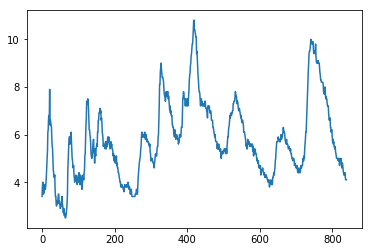

In [14]:
ts = df.values[:,0]
plt.plot(ts)

In [15]:
forecast_length = 10
train_length = len(ts) - forecast_length

tgt_min = ts.min()
ts = ts - tgt_min

# droping the first observation due to lag
target = nd.array(ts[:train_length]).reshape((train_length,1))[1:]

# prediction target
pred_target = nd.array(ts[train_length:]).reshape((forecast_length,1))

# construct lag and trend
trend = nd.arange(train_length).reshape((train_length,1))
lag_sales = nd.array(ts).reshape((train_length,1))

# droping the last observation due to lag
features = nd.concat(trend[:-1],lag_sales[:-1])

# standardize
features_mean = features.mean(axis=0)
features_std = nd.array(features.asnumpy().std(axis=0)).reshape((1,1))
features = (features - features_mean) / features_std

print(features[:5,])
print(target[:5,])


[[-1.7299689  -0.01006812]
 [-1.7257903  -0.00839665]
 [-1.7216116  -0.00756092]
 [-1.717433   -0.00797879]
 [-1.7132543  -0.00965026]]
<NDArray 5x2 @cpu(0)>

[[1.3]
 [1.5]
 [1.4]
 [1. ]
 [1.1]]
<NDArray 5x1 @cpu(0)>


In [16]:
batch_size = 5
train_data = gluon.data.DataLoader(
    gluon.data.ArrayDataset(features, target),
    batch_size=batch_size, shuffle=True)

In [17]:
# Context
ctx = mx.cpu()

# Network
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(1))
    
# Parameter initialization    
net.collect_params().initialize(mx.init.Normal(sigma=0.1), ctx=ctx)

# Trainer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

# Loss
poisson_log_lik = Poisson()

In [18]:


epochs = 50
smoothing_constant = .05
moving_loss = 0
niter = 0
loss_seq = []

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = poisson_log_lik(output, label)
        loss.backward()
        trainer.step(batch_size)
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss

        # correct the bias from the moving averages
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)
        loss_seq.append(est_loss)
    if e % 10 ==0:
        print("Epoch %s. Moving avg of log likelihood: %s" % (e, est_loss)) 
        
        params = net.collect_params() # this returns a ParameterDict

print('The type of "params" is a ',type(params))

# A ParameterDict is a dictionary of Parameter class objects
# therefore, here is how we can read off the parameters from it.

for param in params.values():
    print(param.name,param.data())



Epoch 0. Moving avg of log likelihood: -0.7673279566255256
Epoch 10. Moving avg of log likelihood: -0.5831271599495322
Epoch 20. Moving avg of log likelihood: -0.4607357463736
Epoch 30. Moving avg of log likelihood: -0.7364590749249202
Epoch 40. Moving avg of log likelihood: -0.5246038400344724
The type of "params" is a  <class 'mxnet.gluon.parameter.ParameterDict'>
sequential0_dense0_weight 
[[0.59005   2.3756285]]
<NDArray 1x2 @cpu(0)>
sequential0_dense0_bias 
[3.283443]
<NDArray 1 @cpu(0)>


Text(0,0.5,'est loss')

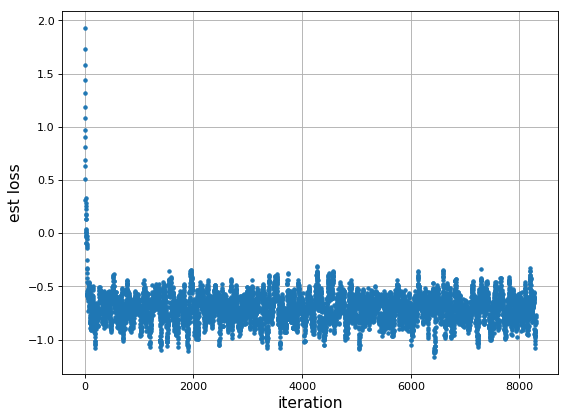

In [19]:


# plot the convergence of the estimated loss function
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6),dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(niter),loss_seq, '.')

# adding some additional bells and whistles to the plot
plt.grid(True,which="both")
plt.xlabel('iteration',fontsize=14)
plt.ylabel('est loss',fontsize=14)



In [21]:
num_hidden = 64
num_outputs = 1
mlp_net = gluon.nn.Sequential()
with mlp_net.name_scope():
    mlp_net.add(gluon.nn.Dense(num_hidden, activation="relu"))
    mlp_net.add(gluon.nn.Dense(num_hidden, activation="relu"))
    mlp_net.add(gluon.nn.Dense(num_outputs))

In [22]:


# context
mlp_ctx = mx.cpu()
# Parameters
mlp_net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=mlp_ctx)
# trainer
trainer = gluon.Trainer(mlp_net.collect_params(), 'sgd', {'learning_rate': .1})
# likelihood
poisson_ll = Poisson()



In [23]:


batch_size = 5
train_data = gluon.data.DataLoader(
    gluon.data.ArrayDataset(features, target),
    batch_size=batch_size, shuffle=True)



In [24]:
epochs = 100
smoothing_constant = .05

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(mlp_ctx)
        label = label.as_in_context(mlp_ctx)
        with autograd.record():
            output = mlp_net(data)
            #print(output)
            #loss = square_loss(output, label)
            loss = poisson_ll(output, label)
            loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()
    if e % 10 ==0:
        print("Epoch %s. Loss: %s" % (e, cumulative_loss))
    
for param in params.values():
    print(param.name,param.data())

Epoch 0. Loss: -526.9359469413757
Epoch 10. Loss: -658.9888117313385
Epoch 20. Loss: -674.360653758049
Epoch 30. Loss: -682.8095963001251
Epoch 40. Loss: -690.6973022222519
Epoch 50. Loss: -701.3677894473076
Epoch 60. Loss: -722.4106270670891
Epoch 70. Loss: -734.8505492210388
Epoch 80. Loss: -743.4608011245728
Epoch 90. Loss: -752.7196062207222
sequential0_dense0_weight 
[[0.59005   2.3756285]]
<NDArray 1x2 @cpu(0)>
sequential0_dense0_bias 
[3.283443]
<NDArray 1 @cpu(0)>


In [25]:
# fit and residual standard errors
fit = mlp_net(features)
se_fit_mlp = (target - fit).asnumpy().std()

# forecast
fct = forecast_poisson(mlp_net,target[train_length-2],
                            features_mean, features_std,
                            forecast_length, train_length) 
# prediction interval
interval = np.concatenate((inverse_logistic(fct - 1.65*se_fit).asnumpy(),
                           inverse_logistic(fct + 1.65*se_fit).asnumpy()), axis=1)

plot_forecast_interval(ts[1:],inverse_logistic(fit),inverse_logistic(fct),interval)

ValueError: operands could not be broadcast together with remapped shapes[original->remapped]: (1, 1) and requested shape (1,)